# PSO


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
from sko.PSO import PSO
import numpy as np
from scipy.fft import dct, idct, dctn, idctn
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['font.weight'] = 'bold'  

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

# -------------------------- Basis Construction & Solver --------------------------

def ndct_basis(x, K):
    """
    Construct the NDCT design matrix A with columns cos(k * π * x), k = 0..K.

    Parameters
    ----------
    x : array_like, shape (m,)
        Sample points scaled to [0, 1].
    K : int
        Number of cosine basis terms.

    Returns
    -------
    A : ndarray, shape (m, K+1)
        NDCT design matrix.
    """
    x = np.asarray(x).reshape(-1)
    ks = np.arange(K + 1)                      # k = 0..K
    return np.cos(np.pi * np.outer(x, ks))     # (m × (K+1)) matrix


def lsq_fit(A, y, lam=0.0):
    """
    Solve the regularized least-squares problem:
        min ||A c - y||_2^2 + λ ||c||_2^2

    Parameters
    ----------
    A : ndarray
        Design matrix.
    y : ndarray
        Observed data.
    lam : float, optional
        Ridge regularization parameter (default: 0.0).

    Returns
    -------
    c : ndarray
        Coefficient vector.
    """
    y = np.asarray(y).reshape(-1)
    n = A.shape[1]

    if lam and lam > 0:
        # Stable ridge regression solution: (AᵀA + λI)c = Aᵀy
        ATA = A.T @ A
        ATy = A.T @ y
        return np.linalg.solve(ATA + lam * np.eye(n), ATy)
    else:
        return np.linalg.lstsq(A, y, rcond=None)[0]

# -------------------------- Model Definition --------------------------

@dataclass
class NDCTModel:
    coeffs: np.ndarray
    K: int
    xmin: float
    xmax: float

    def predict(self, t):
        """
        Evaluate the NDCT model at arbitrary points t.

        Parameters
        ----------
        t : array_like
            Input locations to predict.

        Returns
        -------
        y_pred : ndarray
            Predicted function values.
        """
        t01, _, _ = to_unit_interval(t, self.xmin, self.xmax)  # scale to [0, 1]
        return ndct_basis(t01, self.K) @ self.coeffs


def ndct_fit(x, y, K, lam=0.0):
    """
    Fit an NDCT model by least squares.

    Parameters
    ----------
    x : array_like
        Input sample points (not necessarily uniform).
    y : array_like
        Function values at x.
    K : int
        Number of cosine basis terms.
    lam : float, optional
        Regularization parameter (λ > 0 for ridge regression).

    Returns
    -------
    model : NDCTModel
        Fitted NDCT model instance.
    """
    x01, xmin, xmax = to_unit_interval(x)   # scale domain to [0, 1]
    A = ndct_basis(x01, K)
    c = lsq_fit(A, y, lam=lam)
    return NDCTModel(c, K, xmin, xmax)

# -------------------------- Utility Functions --------------------------

def rmse(a, b):
    """
    Compute Root Mean Squared Error (RMSE).
    """
    a = np.asarray(a)
    b = np.asarray(b)
    return float(np.sqrt(np.mean((a - b) ** 2)))


def to_unit_interval(x, xmin=None, xmax=None):
    """
    Linearly scale arbitrary input domain [xmin, xmax] to [0, 1].

    Parameters
    ----------
    x : array_like
        Input coordinates.
    xmin : float, optional
        Lower bound of the original domain (auto-detected if None).
    xmax : float, optional
        Upper bound of the original domain (auto-detected if None).

    Returns
    -------
    x01 : ndarray
        Scaled coordinates in [0, 1].
    xmin, xmax : float
        Domain bounds used for scaling.
    """
    x = np.asarray(x)
    if xmin is None:
        xmin = float(np.min(x))
    if xmax is None:
        xmax = float(np.max(x))
    x01 = (x - xmin) / (xmax - xmin)
    return x01, xmin, xmax



# 1-D Fourier Series

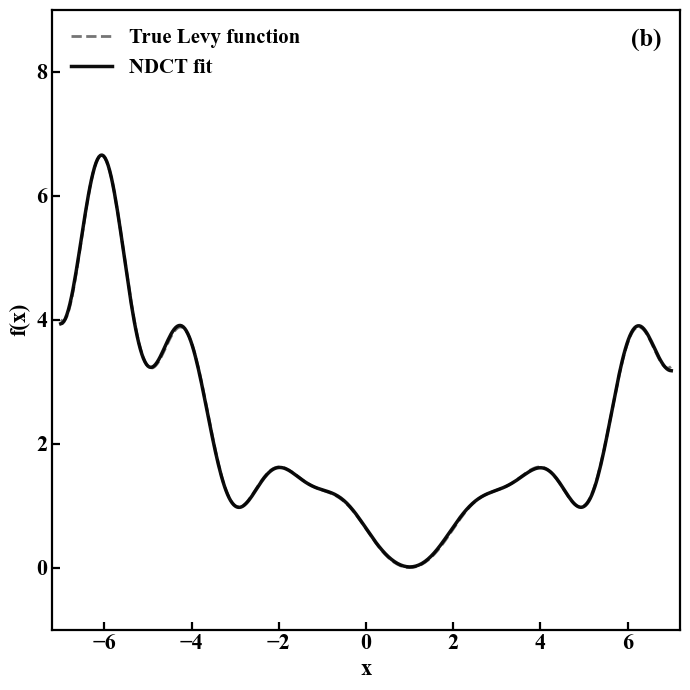

In [4]:
# -*- coding: utf-8 -*-
"""
NDCT fitting on the 1D Levy function with N=10,000 samples.
"""

import numpy as np
import matplotlib.pyplot as plt

# -------------------------- Data Preparation --------------------------
N = 10000
L_interval = 7.0
np.random.seed(38)

# Nonuniform samples in [-L_interval, L_interval]
x1 = np.sort((np.random.rand(N) * 2 - 1) * L_interval)

# Levy function definition
def levy(x):
    w = 1 + (x - 1) / 4
    return np.sin(np.pi * w)**2 + (w - 1)**2 * (1 + np.sin(2 * np.pi * w)**2)

# Add Gaussian noise
noise_level = 0.3
f = levy(x1) + np.random.normal(0, noise_level, size=N)

# -------------------------- NDCT Fitting --------------------------
t_dense = np.linspace(-L_interval, L_interval, 400)
K_dct = 20
model_dct = ndct_fit(x1, f, K=K_dct, lam=1e-6)
y_hat1 = model_dct.predict(t_dense)

# -------------------------- Visualization --------------------------
fig, ax = plt.subplots(figsize=(7, 7))

# NDCT fit (black solid line)
ax.plot(t_dense, y_hat1, label="NDCT fit",
        lw=2.5, color="black", linestyle="-", alpha=0.95, zorder=2)

# Ground truth (gray dashed line)
ax.plot(t_dense, levy(t_dense), label="True Levy function",
        lw=2.0, color="0.4", linestyle="--", alpha=0.9, zorder=1)

# Axis setup
ax.set_xlabel('x', fontsize=16, fontweight='bold', family='Times New Roman')
ax.set_ylabel('f(x)', fontsize=16, fontweight='bold', family='Times New Roman')
ax.set_xlim(-7.2, L_interval + 0.2)
ax.set_ylim(-1, 9)
ax.tick_params(axis='both', direction='in', which='both',
               labelsize=16, width=1.6, length=6)
for spine in ax.spines.values():
    spine.set_linewidth(1.6)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],
          loc='upper left', fontsize=15, frameon=False)

# Panel label
ax.text(0.97, 0.97, "(b)", transform=ax.transAxes,
        fontsize=18, fontweight="bold", ha="right", va="top")

plt.tight_layout()
plt.show()


 # new PSO

In [8]:

from pso_new import PSO_new
from sko.PSO import PSO
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MultipleLocator

# -------------------------- Objective Function --------------------------
def ndct_objective(x_array):
    """
    Objective function evaluated from the NDCT model.
    PSO aims to minimize this predicted function value.
    """
    x = x_array[0]
    y_pred = model_dct.predict(np.array([x]))[0]
    return y_pred

# -------------------------- PSO Execution --------------------------
n_runs = 200  # Number of repeated optimization trials (if needed)

# Initialize hybrid PSO (proposed version)
pso = PSO_new(
    func=ndct_objective, n_dim=1, pop=20, max_iter=200,
    lb=[-7], ub=[7],
    w_min=0.4, w_max=0.9,
    beta_center=0.3, sigma_pert=0.01, anneal_pert=True,
    de_interval=10, de_rate=0.25, de_F=0.5, de_CR=0.9,
    verbose=False,
)
pso.record_mode = True

# Run optimization
best_x, best_y = pso.run(precision=1e-6, N=10)

# -------------------------- Results --------------------------
n_iter_done = len(pso.gbest_y_hist)  # Number of iterations completed
print(f"Actual number of iterations: {n_iter_done}")
print(f"Best position: {best_x}, Best value: {best_y}")




Actual number of iterations: 200
Best position: [1.00561811], Best value: [0.01119522]


In [9]:
import numpy as np
import pandas as pd

positions = np.array(pso.record_value['X'])  

records = []
for it in range(positions.shape[0]):
    for pid in range(positions.shape[1]):
        x_val = positions[it, pid, 0]
        records.append([it, pid, x_val])

df_particles = pd.DataFrame(records, columns=["iteration", "particle_id", "x"])
df_particles.to_csv("particles_trace.csv", index=False)


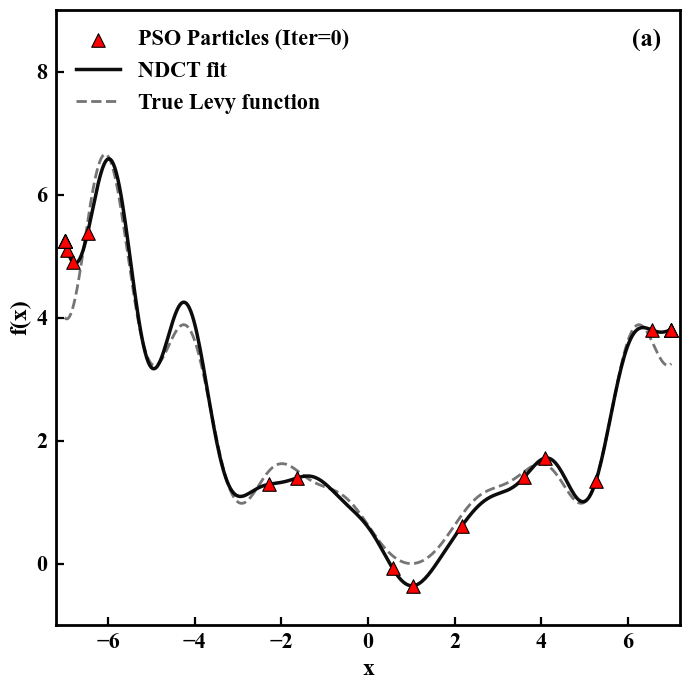

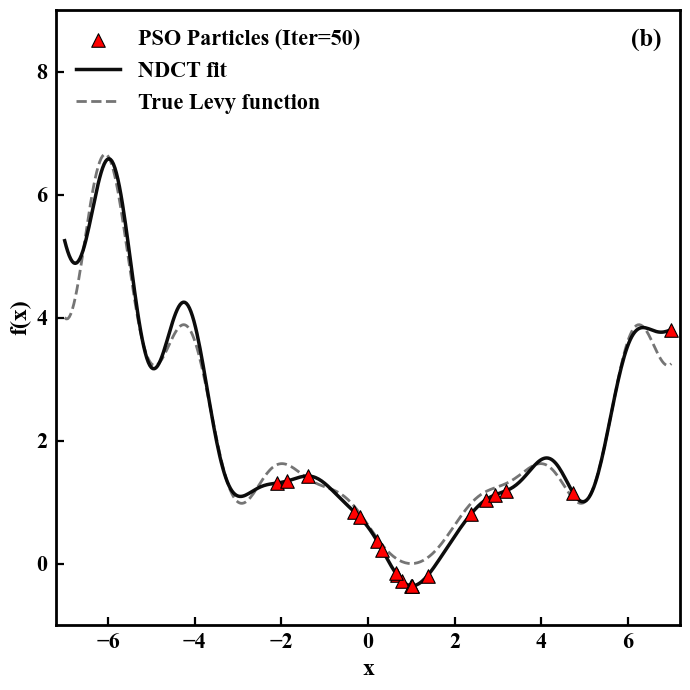

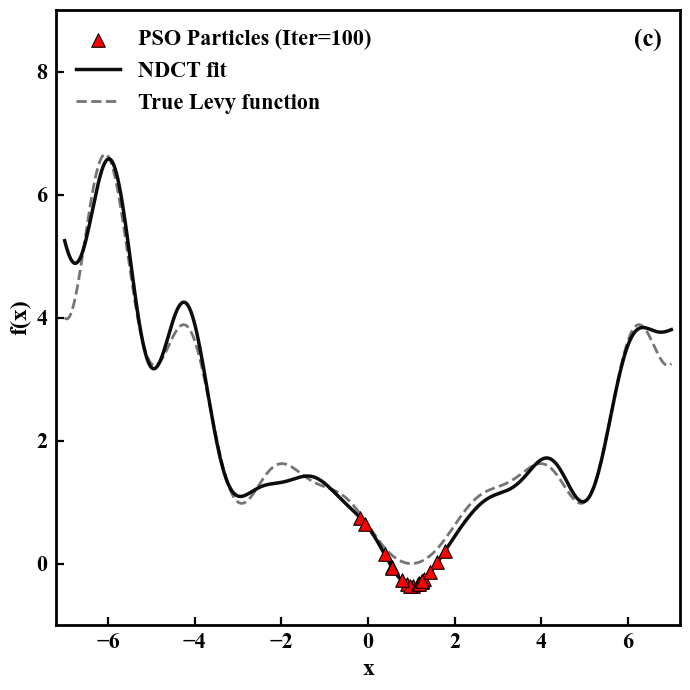

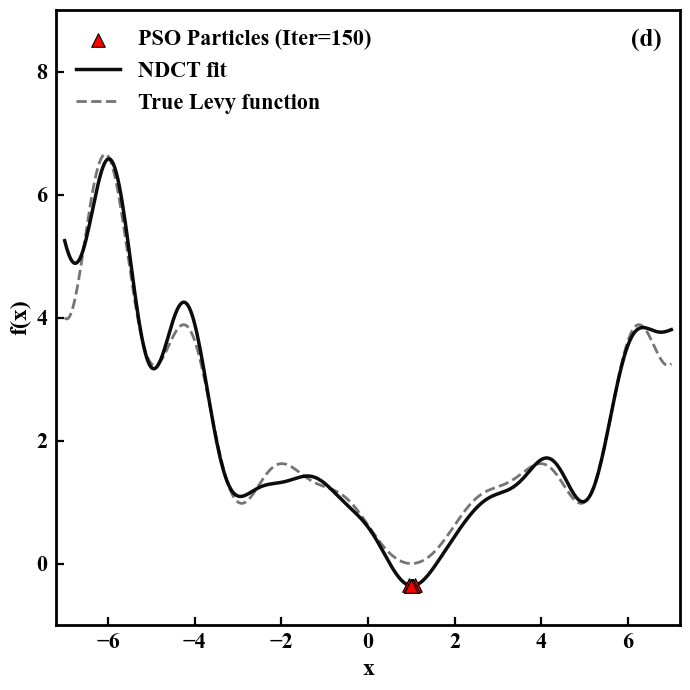

In [10]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------- Levy Function (1D) ----------------------
def levy(x):
    """Classic 1D Levy test function."""
    w = 1 + (x - 1) / 4
    return np.sin(np.pi * w)**2 + (w - 1)**2 * (1 + np.sin(2 * np.pi * w)**2)

# ---------------------- Main Demo ----------------------
if __name__ == "__main__":
    np.random.seed(33)

    # ---------- Step 1: Generate non-uniform samples ----------
    N = 100
    L_interval = 7.0
    x1 = np.sort((np.random.rand(N) * 2 - 1) * L_interval)
    noise_level = 0.3
    f = levy(x1) + np.random.normal(0, noise_level, size=N)

    # ---------- Step 2: NDCT fitting ----------
    t_dense = np.linspace(-L_interval, L_interval, 400)
    K_dct = 18
    model_dct = ndct_fit(x1, f, K=K_dct, lam=1e-6)
    y_hat1 = model_dct.predict(t_dense)

    # ---------- Step 3: Load particle trajectories ----------
    df_particles = pd.read_csv("particles_trace.csv")

    # Selected iteration snapshots and corresponding panel labels
    target_iters = [0, 50, 100, 150]
    panel_tags = ["(a)", "(b)", "(c)", "(d)"]

    for idx, target_iter in enumerate(target_iters):
        fig, ax = plt.subplots(figsize=(7, 7))

        # (1) Ground truth (gray dashed)
        ax.plot(
            t_dense, levy(t_dense), label="True Levy function",
            lw=2.0, color="0.4", linestyle="--", alpha=0.9, zorder=1
        )

        # (2) NDCT fit (black solid)
        ax.plot(
            t_dense, y_hat1, label="NDCT fit",
            lw=2.5, color="black", linestyle="-", alpha=0.95, zorder=2
        )

        # (3) Particle positions (red triangles)
        df_iter = df_particles[df_particles["iteration"] == target_iter]
        particle_positions = df_iter["x"].values
        if "fitness" in df_iter.columns:
            particle_values = df_iter["fitness"].values
        else:
            particle_values = model_dct.predict(particle_positions)

        ax.scatter(
            particle_positions, particle_values,
            c="red", s=95, marker="^", edgecolors="black", linewidths=0.8,
            label=f"PSO Particles (Iter={target_iter})",
            zorder=4
        )

        # ---------- Axis formatting ----------
        ax.set_xlabel('x', fontsize=17, fontweight='bold', family='Times New Roman')
        ax.set_ylabel('f(x)', fontsize=17, fontweight='bold', family='Times New Roman')
        ax.set_xlim(-L_interval - 0.2, L_interval + 0.2)
        ax.set_ylim(-1, 9)
        ax.tick_params(axis='both', direction='in', which='both',
                       labelsize=16, width=1.6, length=6, pad=6)
        for spine in ax.spines.values():
            spine.set_linewidth(2)

        # ---------- Legend ----------
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(
            handles[::-1], labels[::-1],
            loc='upper left', fontsize=16, frameon=False
        )

        # ---------- Panel label ----------
        ax.text(
            0.97, 0.97, panel_tags[idx], transform=ax.transAxes,
            fontsize=18, fontweight="bold", ha="right", va="top"
        )

        # ---------- Save and show ----------
        save_path = fr"D:\lib\gali\Github\fig2-1D-PSO\{panel_tags[idx][1]} particles trace.svg"
        plt.tight_layout()
        plt.savefig(save_path, format="svg", bbox_inches="tight")
        plt.show()


#new plot

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -------------------------- Levy Function --------------------------
def levy(x):
    """1D Levy benchmark function."""
    w = 1 + (x - 1) / 4
    return np.sin(np.pi * w) ** 2 + (w - 1) ** 2 * (1 + np.sin(2 * np.pi * w) ** 2)

# -------------------------- Experimental Parameters --------------------------
N = 100
L_interval = 7.0
K_dct_list = [18, 20, 22]          # Number of cosine basis terms
noise_levels = [0, 0.01, 0.05, 0.1, 0.2, 0.3]
n_repeats = 15                     # Number of random seeds per condition

results = []                       # To collect all experiment outcomes

# -------------------------- Batch Experiments --------------------------
for K_dct in K_dct_list:
    for noise_level in noise_levels:
        for seed in range(n_repeats):
            np.random.seed(seed * 4)

            # Generate nonequispaced samples
            x1 = np.sort((np.random.rand(N) * 2 - 1) * L_interval)
            y_true = levy(x1)
            f = y_true + np.random.normal(0, noise_level, size=N)

            # NDCT fitting
            model_dct = ndct_fit(x1, f, K=K_dct, lam=1e-6)
            y_pred = model_dct.predict(x1)

            # Define the NDCT-based objective for PSO
            def ndct_objective(x_array):
                x = x_array[0]
                return model_dct.predict(np.array([x]))[0]

            # Run hybrid PSO
            pso = PSO_new(
                func=ndct_objective, n_dim=1, pop=20, max_iter=200,
                lb=[-L_interval], ub=[L_interval],
                w_min=0.4, w_max=0.9,
                beta_center=0.3, sigma_pert=0.01, anneal_pert=True,
                de_interval=10, de_rate=0.25, de_F=0.5, de_CR=0.9,
                verbose=False,
            )
            pso.record_mode = True
            best_x, best_y = pso.run(precision=1e-6, N=10)

            # Record results
            results.append({
                "K_dct": K_dct,
                "Noise": noise_level,
                "Seed": seed,
                "Best_x": best_x,
                "Best_y": best_y,
            })

# -------------------------- Output Results --------------------------
df_results = pd.DataFrame(results)
print(df_results)

# Save all results to CSV
df_results.to_csv("pso_ndct_results_all.csv", index=False)


     K_dct  Noise  Seed                Best_x                   Best_y
0       18    0.0     0  [0.9260993467360754]  [-0.015712919644858103]
1       18    0.0     1  [0.9141834597624354]  [-0.012450027172306921]
2       18    0.0     2  [0.9356553297354784]  [-0.020403647642007416]
3       18    0.0     3  [0.9408125544625541]  [-0.020482670522871782]
4       18    0.0     4  [0.8856793180782696]   [-0.03208061709105392]
..     ...    ...   ...                   ...                      ...
265     22    0.3    10  [0.7218205810743014]    [0.16511179560469014]
266     22    0.3    11   [0.915198758825654]   [-0.02390922483772895]
267     22    0.3    12  [0.8991985583525955]   [-0.04690265061914123]
268     22    0.3    13  [0.9259826504378336]    [-0.3328992844233907]
269     22    0.3    14  [1.6665925381135096]   [-0.22876365122596443]

[270 rows x 5 columns]


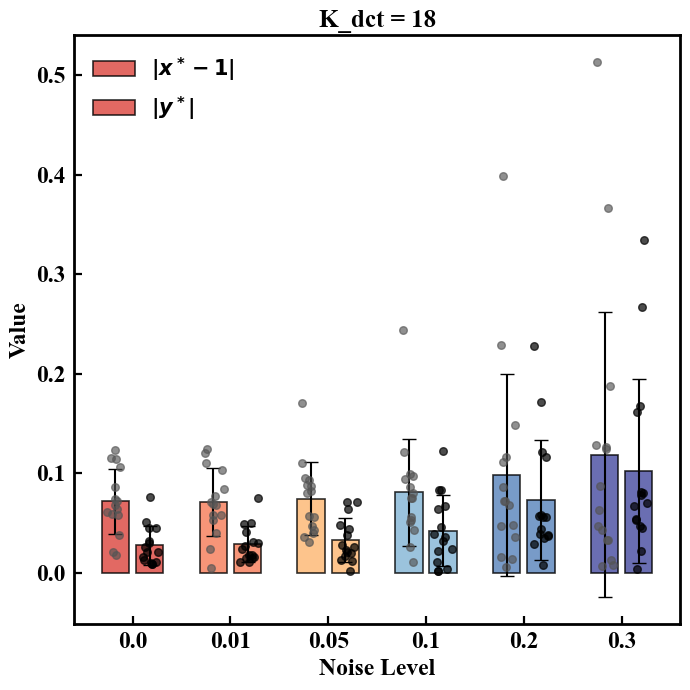

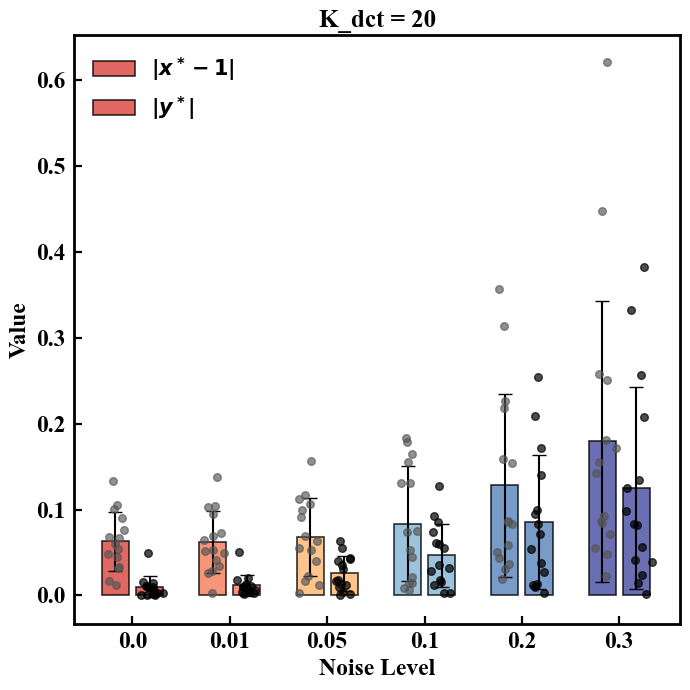

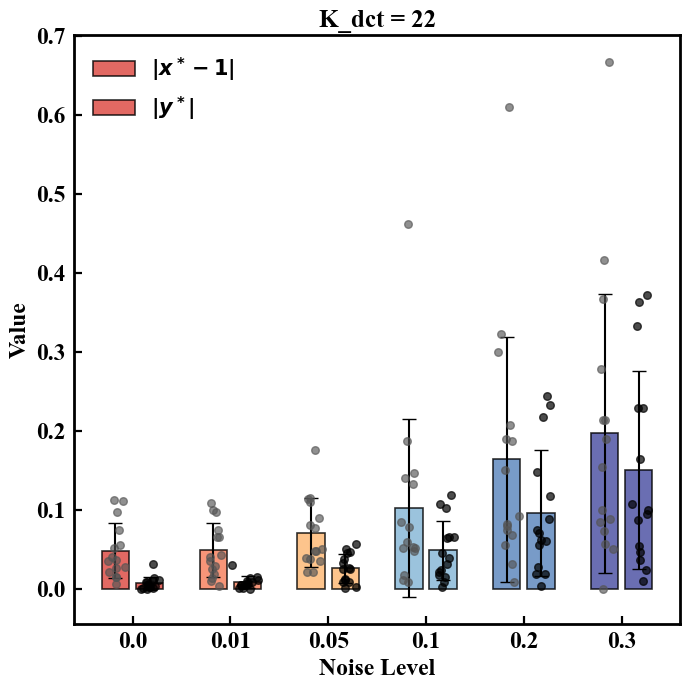

In [14]:
df_results = df_results.copy()
df_results["Best_x"] = df_results["Best_x"].astype(float)
df_results["Best_y"] = df_results["Best_y"].astype(float)

# Compute absolute deviation metrics
df_results["Delta_x"] = (df_results["Best_x"] - 1.0).abs()
df_results["Delta_y"] = df_results["Best_y"].abs()


# ---------------------------------------------------------------------
# Helper: Grouped bar chart with scatter overlays
# ---------------------------------------------------------------------
def plot_grouped_bar_with_scatter(df, col1, col2, ylabel1, ylabel2, fname, title=None):
    """
    Draw grouped bar plots (mean ± std) for two target columns,
    overlaid with individual scatter points for all trials.
    """

    # Aggregate mean/std by noise level
    df_summary = df.groupby("Noise", as_index=False).agg(
        Mean1=(col1, "mean"), Std1=(col1, "std"),
        Mean2=(col2, "mean"), Std2=(col2, "std"),
    )
    noise_order = sorted(df_summary["Noise"].to_numpy())
    xpos = np.arange(len(noise_order))

    # Extract values in order
    means1 = np.array([df_summary.loc[df_summary["Noise"] == n, "Mean1"].values[0] for n in noise_order])
    stds1  = np.array([df_summary.loc[df_summary["Noise"] == n, "Std1"].values[0]  for n in noise_order])
    means2 = np.array([df_summary.loc[df_summary["Noise"] == n, "Mean2"].values[0] for n in noise_order])
    stds2  = np.array([df_summary.loc[df_summary["Noise"] == n, "Std2"].values[0]  for n in noise_order])

    fig, ax = plt.subplots(figsize=(7, 7))

    # Custom color palette (consistent with prior NDCT/PSO figures)
    colors = {
        "1": "#DB443C",  # red
        "2": "#F57B56",  # coral
        "3": "#FDB670",  # gold
        "4": "#82B5D5",  # light blue
        "5": "#5682BB",  # steel blue
        "6": "#454A9F",  # deep blue
    }
    color_list = list(colors.values())

    # Bar layout parameters
    bar_width = 0.28
    group_spacing = 0.35

    # --- Left group: Delta_x ---
    ax.bar(
        xpos - group_spacing/2, means1, yerr=stds1, capsize=5,
        width=bar_width,
        color=[color_list[i % len(color_list)] for i in range(len(noise_order))],
        edgecolor="black", linewidth=1.2, alpha=0.8,
        label=ylabel1
    )

    # --- Right group: Delta_y ---
    ax.bar(
        xpos + group_spacing/2, means2, yerr=stds2, capsize=5,
        width=bar_width,
        color=[color_list[i % len(color_list)] for i in range(len(noise_order))],
        edgecolor="black", linewidth=1.2, alpha=0.8,
        label=ylabel2
    )

    # --- Scatter overlay (jittered) ---
    for i, n in enumerate(noise_order):
        vals1 = df.loc[df["Noise"] == n, col1].to_numpy(dtype=float)
        vals2 = df.loc[df["Noise"] == n, col2].to_numpy(dtype=float)

        # Add horizontal jitter for visual separation
        x_jit1 = np.random.normal(loc=xpos[i] - group_spacing/2, scale=0.05, size=vals1.shape[0])
        x_jit2 = np.random.normal(loc=xpos[i] + group_spacing/2, scale=0.05, size=vals2.shape[0])

        ax.scatter(x_jit1, vals1, color="#555555", s=30, alpha=0.65, zorder=3)
        ax.scatter(x_jit2, vals2, color="black", s=30, alpha=0.7, zorder=3)

    # --- Axes & styling ---
    ax.set_xticks(xpos)
    ax.set_xticklabels([str(n) for n in noise_order])
    ax.set_xlabel("Noise Level", fontsize=17, fontweight="bold", family="Times New Roman")
    ax.set_ylabel("Value", fontsize=17, fontweight="bold", family="Times New Roman")
    ax.tick_params(axis='both', direction='in', which='both',
                   labelsize=17, width=1.6, length=6, pad=6)
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    if title:
        ax.set_title(title, fontsize=18, fontweight="bold")

    ax.legend(fontsize=15, frameon=False)
    plt.tight_layout()
    plt.savefig(fname, dpi=600, bbox_inches="tight")
    plt.show()


# ---------------------------------------------------------------------
# Generate separate figures for each K_dct
# ---------------------------------------------------------------------
for k in sorted(df_results["K_dct"].unique()):
    df_sub = df_results[df_results["K_dct"] == k].copy()
    plot_grouped_bar_with_scatter(
        df_sub,
        "Delta_x", "Delta_y",
        r"$|x^* - 1|$", r"$|y^*|$",
        f"pso_combined_K{k}.svg",
        title=f"K_dct = {k}"
    )

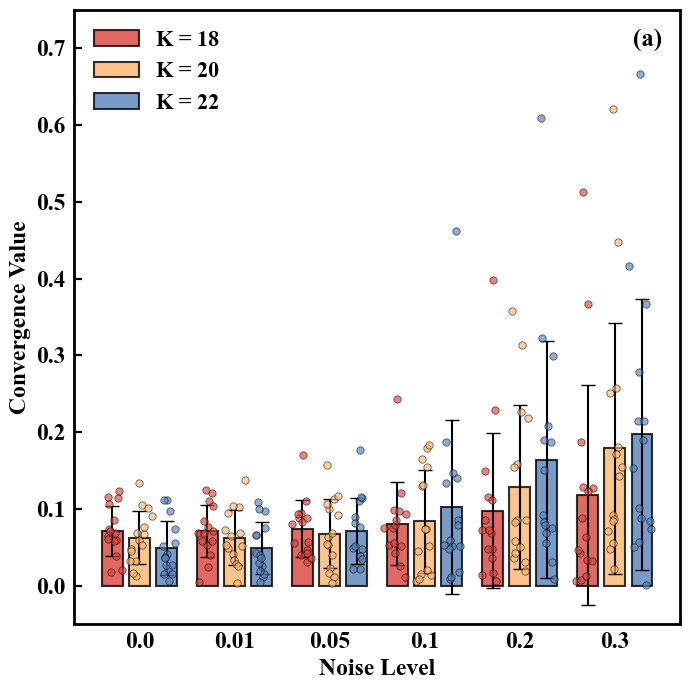

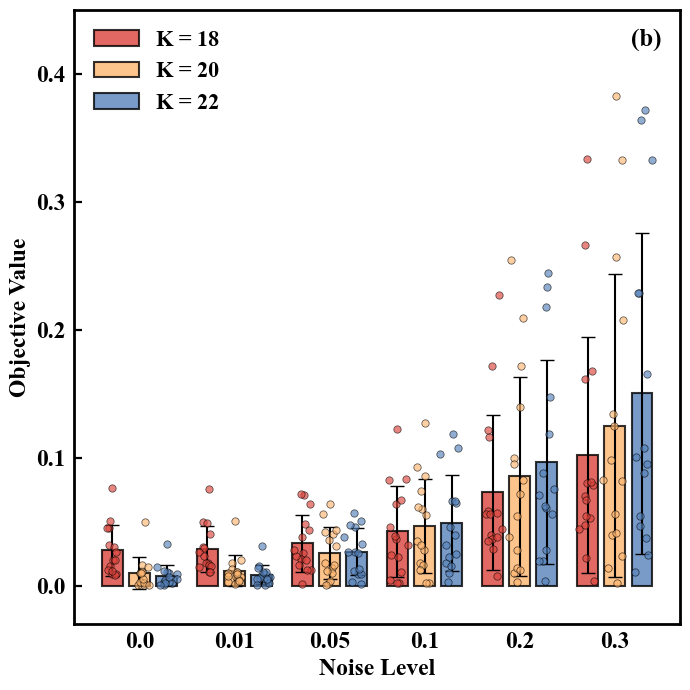

In [16]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

# ==========================================================
# Load experimental results
# ==========================================================
df_loaded = pd.read_csv("pso_ndct_results_all.csv")

# Convert stringified arrays (from CSV) to numeric scalars
df_results = df_loaded.copy()
df_results["Best_x"] = df_results["Best_x"].apply(
    lambda x: float(ast.literal_eval(x)[0]) if isinstance(x, str) else float(x)
)
df_results["Best_y"] = df_results["Best_y"].apply(
    lambda x: float(ast.literal_eval(x)[0]) if isinstance(x, str) else float(x)
)

# Compute absolute deviations
df_results["Delta_x"] = (df_results["Best_x"] - 1.0).abs()
df_results["Delta_y"] = df_results["Best_y"].abs()


# ==========================================================
# Plot function: multi-K comparison with scatter overlay
# ==========================================================
def plot_multiK_with_scatter(df, col, ylabel, fname=None, tag=None, ylim=None):
    """
    Plot grouped bar charts comparing multiple K_dct values across noise levels.

    Each group (noise level) shows mean ± std for each K_dct,
    with overlaid jittered scatter points for individual runs.
    """
    # Summary statistics
    df_summary = df.groupby(["Noise", "K_dct"], as_index=False).agg(
        Mean=(col, "mean"), Std=(col, "std")
    )
    noise_order = sorted(df["Noise"].unique())
    k_order = sorted(df["K_dct"].unique())
    xpos = np.arange(len(noise_order))

    fig, ax = plt.subplots(figsize=(7, 7))

    # Visual parameters
    bar_width = 0.22
    color_map = {18: "#DB443C", 20: "#FDB670", 22: "#5682BB"}

    # ------------------ Bars and scatter points ------------------
    for j, k in enumerate(k_order):
        means = [
            df_summary[(df_summary["Noise"] == n) & (df_summary["K_dct"] == k)]["Mean"].values[0]
            for n in noise_order
        ]
        stds = [
            df_summary[(df_summary["Noise"] == n) & (df_summary["K_dct"] == k)]["Std"].values[0]
            for n in noise_order
        ]
        bar_pos = xpos + (j - len(k_order) / 2) * bar_width * 1.3

        # Bar plot
        ax.bar(
            bar_pos, means, yerr=stds, capsize=5,
            width=bar_width, color=color_map[k],
            edgecolor="black", linewidth=1.5, alpha=0.8,
            label=f"K = {k}"
        )

        # Scatter overlay (with horizontal jitter)
        for i, n in enumerate(noise_order):
            vals = df.loc[(df["Noise"] == n) & (df["K_dct"] == k), col].to_numpy(dtype=float)
            x_jit = np.random.normal(loc=bar_pos[i], scale=0.05, size=vals.shape[0])
            ax.scatter(
                x_jit, vals,
                color=color_map[k], s=28, alpha=0.65, zorder=3,
                edgecolor="black", linewidth=0.55
            )

    # ------------------ Axes and style ------------------
    offset = -0.14
    ax.set_xticks(xpos + offset)
    ax.set_xticklabels([str(n) for n in noise_order])
    ax.set_xlabel("Noise Level", fontsize=17, fontweight="bold", family="Times New Roman")
    ax.set_ylabel(ylabel, fontsize=17, fontweight="bold", family="Times New Roman")
    ax.tick_params(axis='both', direction='in', which='both',
                   labelsize=17, width=1.6, length=6, pad=6)
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    if ylim:
        ax.set_ylim(ylim)

    # Legend and annotation
    ax.legend(fontsize=16, frameon=False, loc="upper left")
    ax.tick_params(axis="x", bottom=False, top=False)

    if tag:
        ax.text(0.97, 0.97, tag, transform=ax.transAxes,
                ha="right", va="top", fontsize=18, fontweight="bold")

    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=600, bbox_inches="tight")
    plt.show()


# ==========================================================
# Generate panels for |x* - 1| and |y*|
# ==========================================================
# (a) Convergence value (Δx)
plot_multiK_with_scatter(
    df_results, "Delta_x",
    ylabel="Convergence Value",
    fname="multiK_delta_x.svg",
    tag="(a)",
    ylim=(-0.05, 0.75)
)

# (b) Objective value (Δy)
plot_multiK_with_scatter(
    df_results, "Delta_y",
    ylabel="Objective Value",
    fname="multiK_delta_y.svg",
    tag="(b)",
    ylim=(-0.03, 0.45)
)